In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader


import copy
import time
import os
import sys
import random

In [176]:
batch_size = 4096

In [177]:
# read the data from /input/train.csv
data = pd.read_csv("train.csv")

In [199]:
real_test_df = pd.read_csv('test.csv')

In [204]:
# split the data into train, validation and test sets
train_df, test_df = train_test_split(
    data, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(
    train_df, test_size=0.11, random_state=42)

In [205]:
cols2use = train_df.columns.tolist()
cols2use.remove('id')
cols2use.remove('Class')

In [206]:
cols2use

['Mean_Integrated',
 'SD',
 'EK',
 'Skewness',
 'Mean_DMSNR_Curve',
 'SD_DMSNR_Curve',
 'EK_DMSNR_Curve',
 'Skewness_DMSNR_Curve']

In [217]:
class PulsarDataset(Dataset):

    def __init__(self, df, feature_columns=cols2use, with_labels=True):
        
        self.with_labels = with_labels
        self.ids = df.id.values
        
        #FEATURES
        self.features = df[feature_columns].values
        
        # LABELS
        if with_labels:
            self.labels = df.Class.values

    
    def __len__(self):
        return len(self.ids)
        
    def __getitem__(self, idx):

        ids = self.ids[idx]
        features = self.features[idx]
        
        targets = ''
        if self.with_labels:
            targets = self.labels[idx]
            sample = {'ids':ids,'features':features,'targets':targets}
        else:
            sample = {'ids':ids,'features':features}
       
        
        return sample

In [218]:
dataframes = {}

for phase in ['train', 'test', 'val', 'real_test']:
    dataframes[phase] = df=locals()[phase+'_df']

In [219]:
datasets = {}
dataloaders = {}
for split in ['train','val','test', 'real_test']: 
    shuffle = False
    with_labels = True
    if split=="train":
        shuffle = True
    if split=="real_test":
        with_labels = False
    datasets[split] =  PulsarDataset(df=dataframes[split], with_labels=with_labels)

    dataloaders[split] = DataLoader(datasets[split], batch_size=batch_size,
                              shuffle=shuffle)

In [220]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val','test', 'real_test']}
dataset_sizes

{'train': 94168, 'val': 11639, 'test': 11757, 'real_test': 78377}

In [185]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, l1_weight, l2_weight, optimizer, scheduler, num_epochs=1,model_filename=''):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100000000000000
    iters = []
    training_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        iters.append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for output in dataloaders[phase]:
                features = output['features'].float()
                targets = output['targets']
                targets = torch.reshape(targets, (targets.size(0), 1))
                features = features.to(device)
                targets = targets.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                outputs = model(features)
                

                targets = torch.flatten(targets)
                
                loss = criterion(outputs, targets)
                loss = loss.to(device)
                
#                 l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
#                 l1_penalty = l1_penalty.to(device)
#                 l2_penalty = l2_weight * sum([(p**2).sum() for p in model.parameters()])
#                 l2_penalty = l2_penalty.to(device)
#                 loss += l1_penalty + l2_penalty
                
                if phase == 'train':
                    scheduler.step()
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * targets.size(0)
                
                


            epoch_loss = running_loss / dataset_sizes[phase]
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print('PASSED')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Performance on test_set')
                eval_model(model,criterion, l1_weight, l2_weight, optimizer)
                if model_filename!='':
                    torch.save(model.state_dict(), os.path.join(model_filename))
                    
            if phase == 'train':
                training_losses.append(epoch_loss)
            elif phase == 'val':
                val_losses.append(epoch_loss)

        plt.plot(iters, training_losses, label='training loss')
        plt.plot(iters, val_losses, label='validation loss')
        plt.xlabel("Epoch")
        plt.ylabel("Losses")
        plt.legend(loc='best')
        plt.show()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [186]:
def eval_model(model, criterion, l1_weight, l2_weight, optimizer):
    since = time.time()
    phase = 'test'
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0

    
    # Iterate over data.
    predictions = []
    tars = []
    for output in dataloaders[phase]:
        features = output['features'].float()
        targets = output['targets']
        targets = torch.reshape(targets, (targets.size(0), 1))
        features = features.to(device)
        targets = targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()



        with torch.no_grad():
            outputs = model(features)


            targets = torch.flatten(targets)
            loss = criterion(outputs, targets)
            loss = loss.to(device)            
            
#             l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
#             l1_penalty = l1_penalty.to(device)
#             l2_penalty = l2_weight * sum([(p**2).sum() for p in model.parameters()])
#             l2_penalty = l2_penalty.to(device)
#             loss += l1_penalty + l2_penalty
            
        # statistics
        running_loss += loss.item() * targets.size(0)
        

    eval_loss = running_loss / dataset_sizes[phase]

    
    time_elapsed = time.time() - since
    print('Evaluation Loss: {:.4f}'.format(eval_loss))
    
    return eval_loss

In [235]:
def predict(model, criterion, l1_weight, l2_weight, optimizer, phase):
    
    since = time.time()
    model.eval()   # Set model to evaluate mode
    
    # Iterate over data.
    
    count =0
    

    names = []
    predictions = []
    tars = []

    for output in dataloaders[phase]:
        ids = output['ids']
        features = output['features'].float()
        features = features.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()



        with torch.no_grad():
            outputs = model(features)
            
            #outputs = torch.reshape(outputs, (outputs.size(0), 1))
            
            outputs =  outputs.squeeze()
            outputs.size()
            
            if count == 0:
                print('Outputs shape:', outputs.shape)

                

                predictions = np.array([np.array(outputs[:,0]), np.array(outputs[:,1]), np.array(ids)])
            else:
                predictions = np.append(predictions, [np.array(outputs[:,0]), np.array(outputs[:,1]), np.array(ids)], axis=1)
            count += 1

    time_elapsed = time.time() - since
    
    #pred_df = pd.DataFrame(predictions.transpose(1,0), columns=['prob_1', 'prob_2', 'ids'])
    #return pred_df
    return predictions

In [188]:
class myModel(nn.Module):
    
    def __init__(self, num_nodes=100):
        super(myModel, self).__init__()
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        
        self.final = torch.nn.Sequential(
        torch.nn.Linear(8, 256, bias = False),
        torch.nn.BatchNorm1d(256),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(256, 128, bias = False),
        torch.nn.BatchNorm1d(128),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(128, 2, bias = True),
        # torch.nn.BatchNorm1d(64),
        # torch.nn.ReLU(),
        # #torch.nn.Dropout(p=0.3, inplace=False),
        # #torch.nn.Linear(128, 64, bias = False),
        # #torch.nn.ReLU(),
        # #torch.nn.BatchNorm1d(num_nodes),
        # #torch.nn.Linear(64, 1, bias=True)
        # #torch.nn.ReLU(),
        # torch.nn.Linear(64, 2, bias=True),
        # torch.nn.Softmax()
        )

        
    def forward(self, features):
        all_features = features
        final_out = self.final(all_features)
        return final_out

In [189]:
model = myModel(64)

In [190]:
criterion = torch.nn.CrossEntropyLoss()

In [191]:
# Observe that all parameters are being optimized

#optimizer = torch.optim.SGD(model.parameters(), lr=0.0000008, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

l1_weight = 0e-4
l2_weight = 0e-4

In [195]:
# one cycle LR

epochs = 100

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.03, steps_per_epoch=len(dataloaders['train']), three_phase = False, epochs=epochs)

In [196]:
x = torch.tensor([[2,1]])
x= x.flatten()
x.size()

torch.Size([2])

----------
Epoch 1/100
train Loss: 0.0984
val Loss: 0.0703
PASSED
Performance on test_set
Evaluation Loss: 0.0655


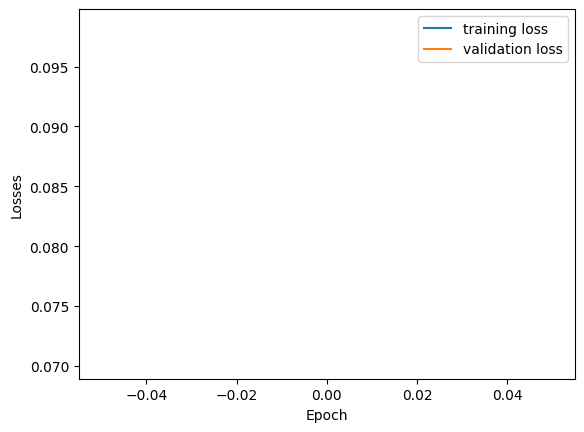

----------
Epoch 2/100
train Loss: 0.0600
val Loss: 0.0533
PASSED
Performance on test_set
Evaluation Loss: 0.0476


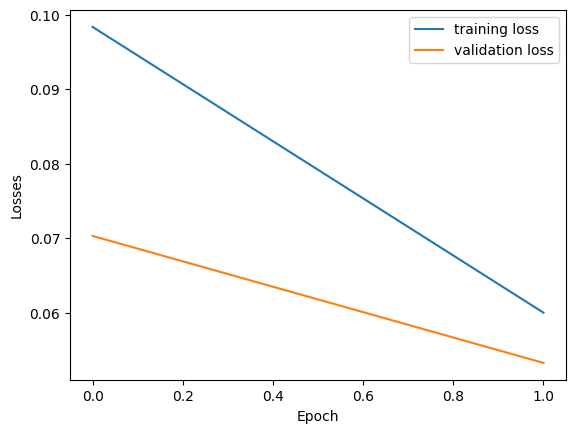

----------
Epoch 3/100
train Loss: 0.0496
val Loss: 0.0485
PASSED
Performance on test_set
Evaluation Loss: 0.0421


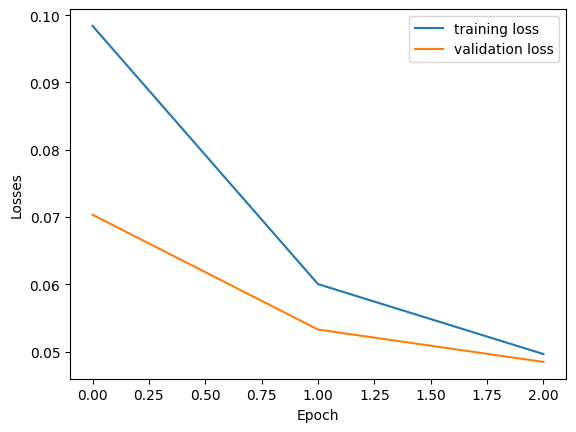

----------
Epoch 4/100
train Loss: 0.0464
val Loss: 0.0477
PASSED
Performance on test_set
Evaluation Loss: 0.0413


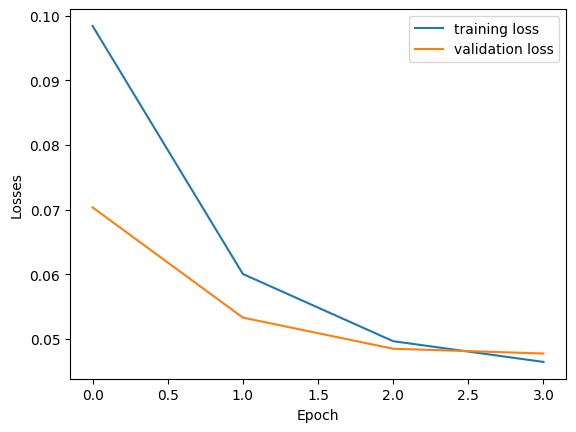

----------
Epoch 5/100
train Loss: 0.0449
val Loss: 0.0460
PASSED
Performance on test_set
Evaluation Loss: 0.0388


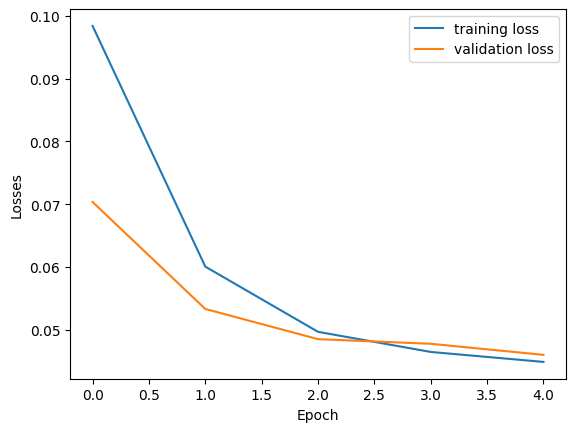

----------
Epoch 6/100
train Loss: 0.0438
val Loss: 0.0454
PASSED
Performance on test_set
Evaluation Loss: 0.0385


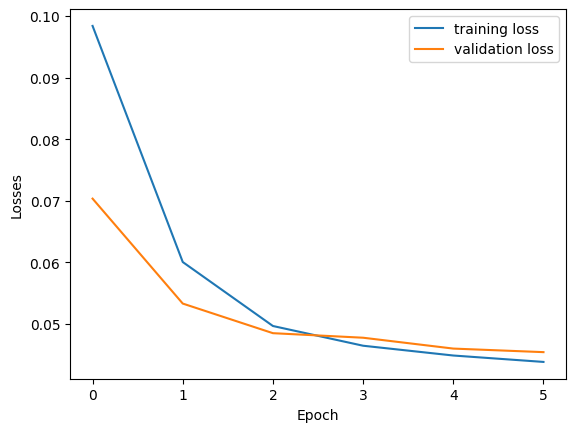

----------
Epoch 7/100
train Loss: 0.0426
val Loss: 0.0445
PASSED
Performance on test_set
Evaluation Loss: 0.0375


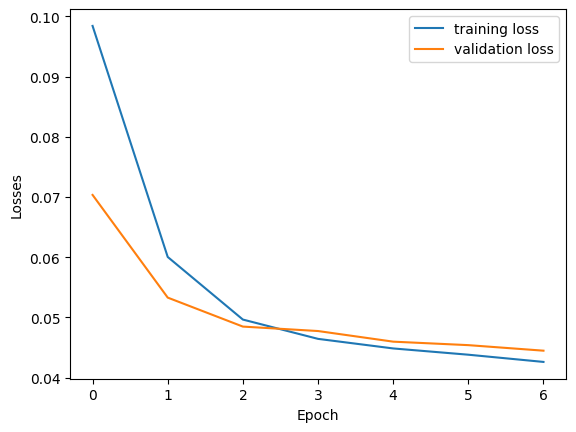

----------
Epoch 8/100
train Loss: 0.0419
val Loss: 0.0436
PASSED
Performance on test_set
Evaluation Loss: 0.0369


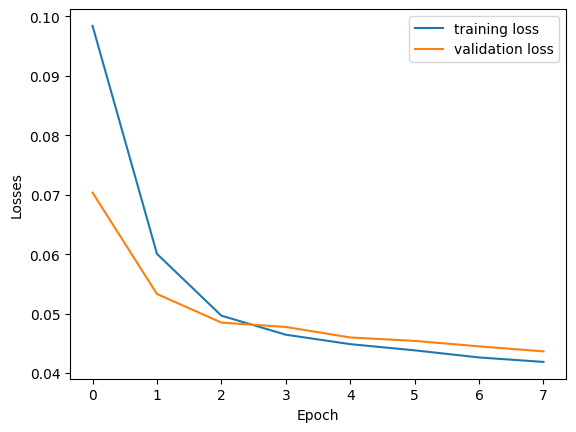

----------
Epoch 9/100
train Loss: 0.0409
val Loss: 0.0440


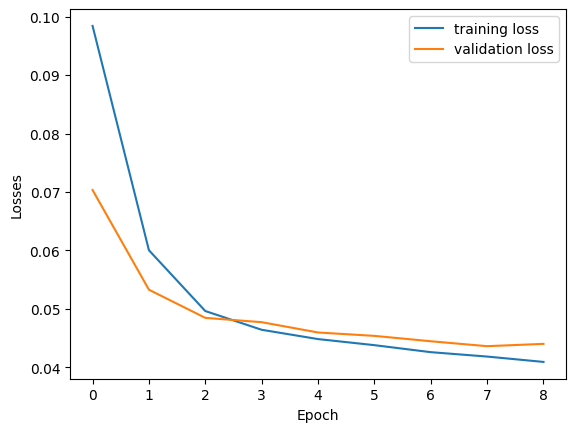

----------
Epoch 10/100
train Loss: 0.0406
val Loss: 0.0418
PASSED
Performance on test_set
Evaluation Loss: 0.0353


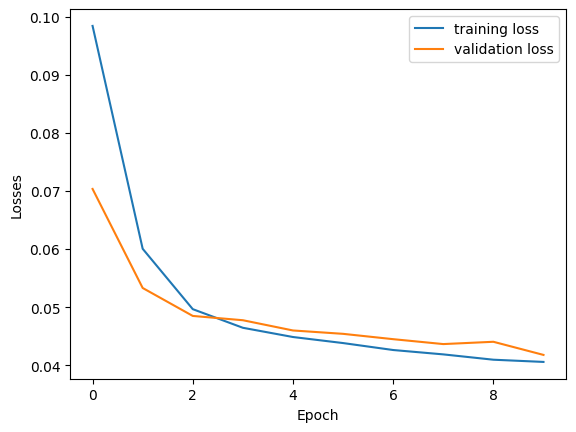

----------
Epoch 11/100
train Loss: 0.0400
val Loss: 0.0446


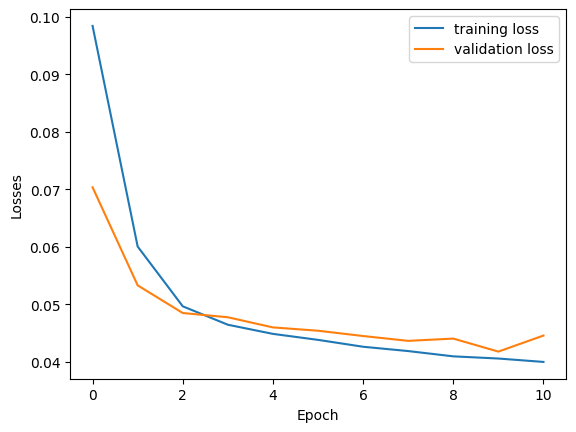

----------
Epoch 12/100
train Loss: 0.0396
val Loss: 0.0428


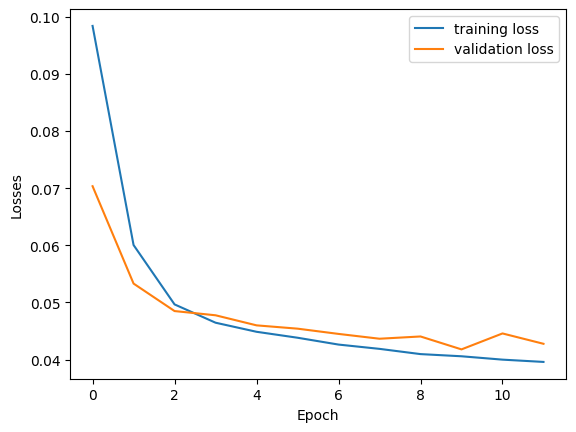

----------
Epoch 13/100
train Loss: 0.0391
val Loss: 0.0403
PASSED
Performance on test_set
Evaluation Loss: 0.0346


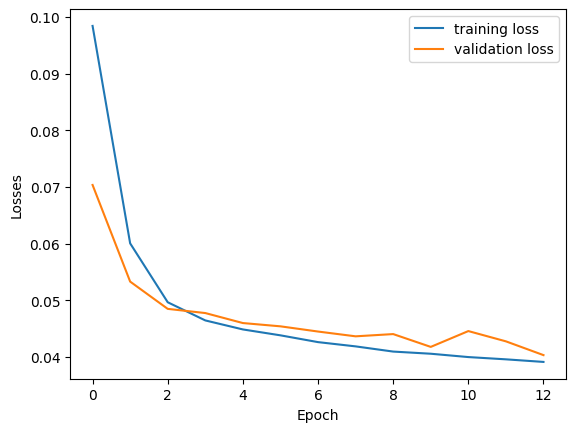

----------
Epoch 14/100
train Loss: 0.0385
val Loss: 0.0403
PASSED
Performance on test_set
Evaluation Loss: 0.0342


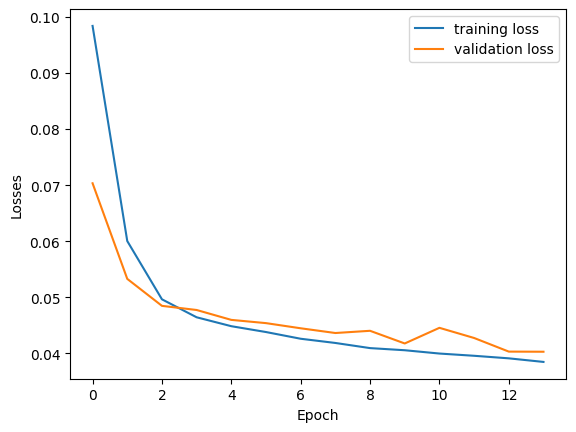

----------
Epoch 15/100
train Loss: 0.0384
val Loss: 0.0413


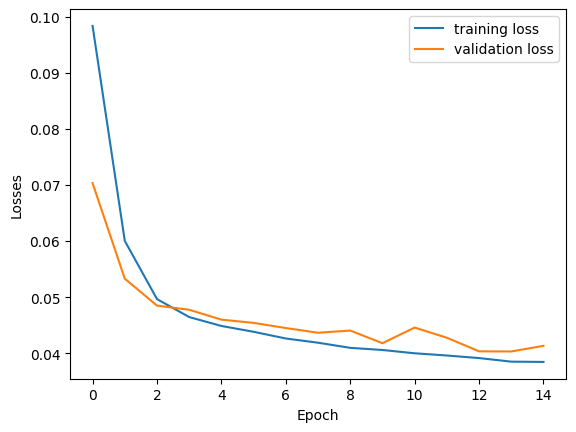

----------
Epoch 16/100
train Loss: 0.0381
val Loss: 0.0405


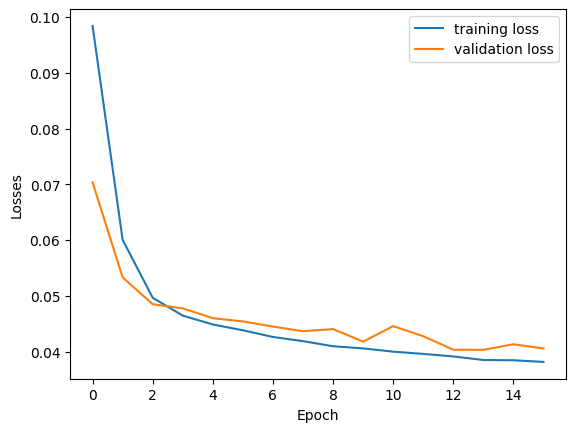

----------
Epoch 17/100
train Loss: 0.0370
val Loss: 0.0400
PASSED
Performance on test_set
Evaluation Loss: 0.0340


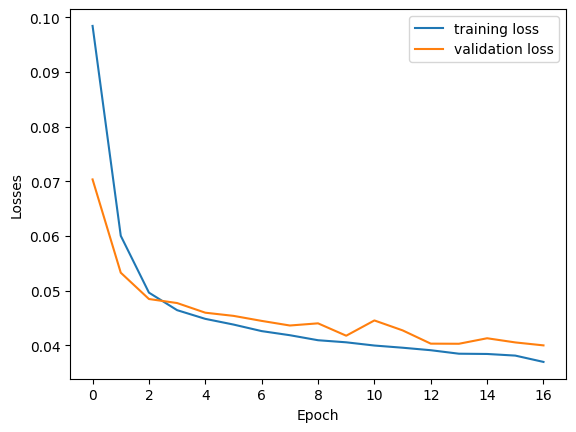

----------
Epoch 18/100
train Loss: 0.0367
val Loss: 0.0405


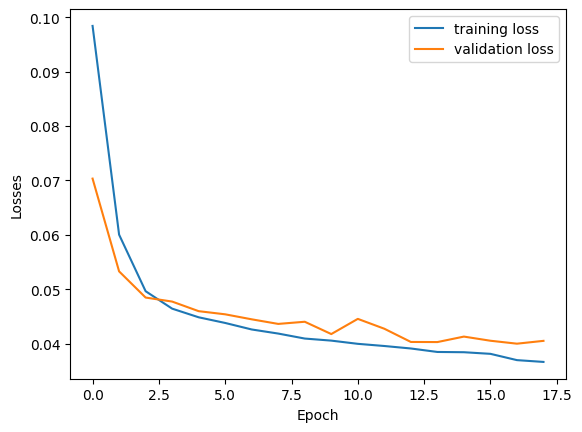

----------
Epoch 19/100
train Loss: 0.0378
val Loss: 0.0471


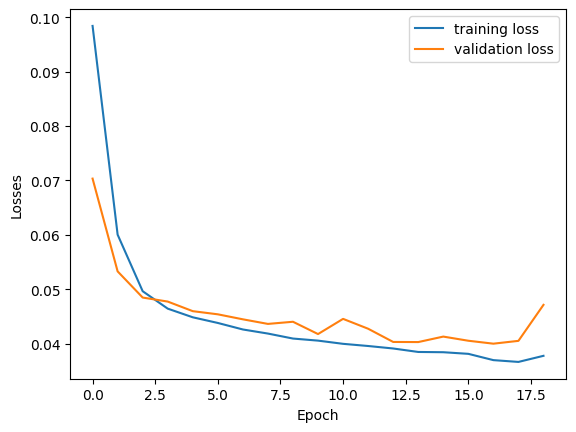

----------
Epoch 20/100
train Loss: 0.0367
val Loss: 0.0389
PASSED
Performance on test_set
Evaluation Loss: 0.0341


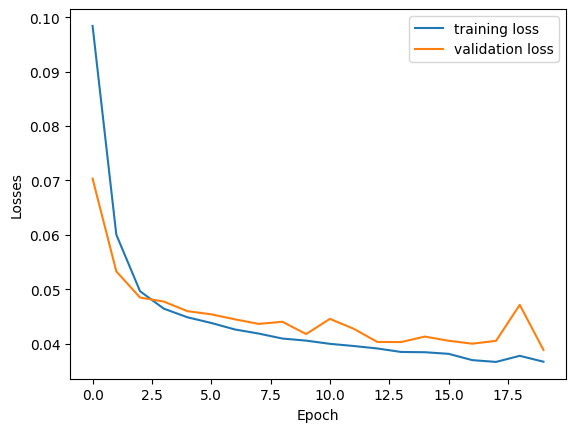

----------
Epoch 21/100
train Loss: 0.0370
val Loss: 0.0383
PASSED
Performance on test_set
Evaluation Loss: 0.0351


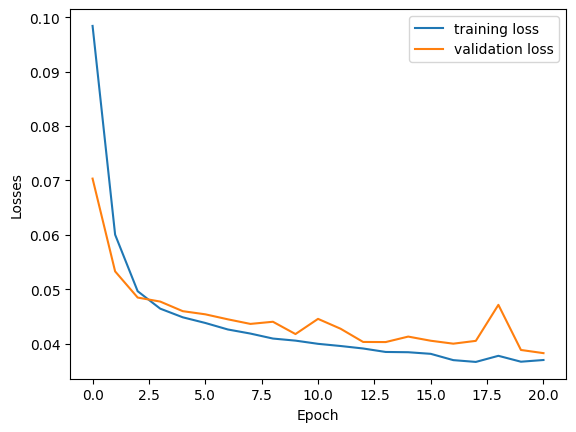

----------
Epoch 22/100
train Loss: 0.0369
val Loss: 0.0378
PASSED
Performance on test_set
Evaluation Loss: 0.0325


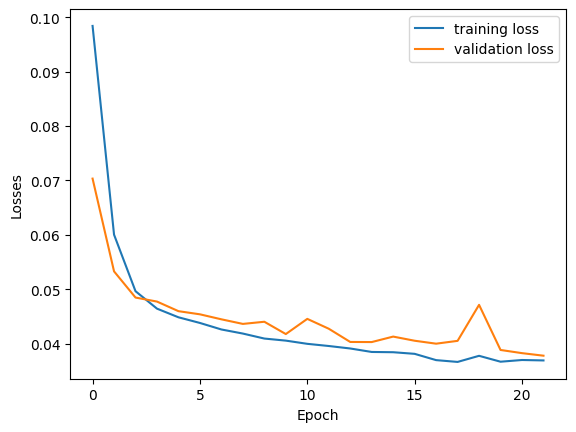

----------
Epoch 23/100
train Loss: 0.0363
val Loss: 0.0392


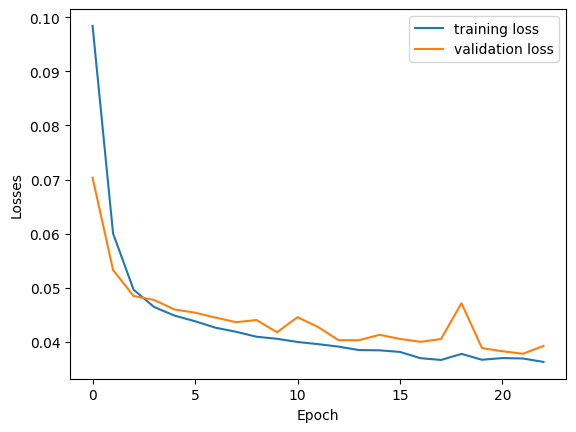

----------
Epoch 24/100
train Loss: 0.0351
val Loss: 0.0379


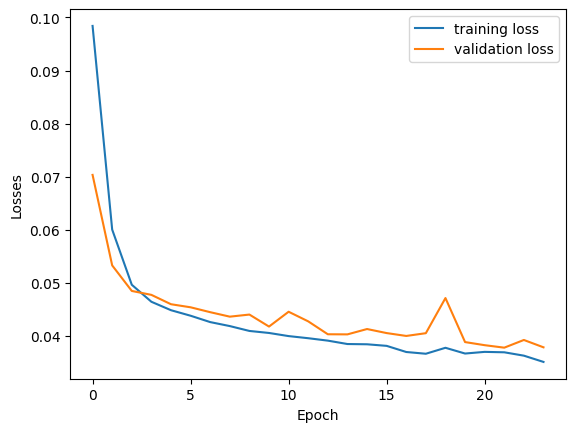

----------
Epoch 25/100
train Loss: 0.0358
val Loss: 0.0433


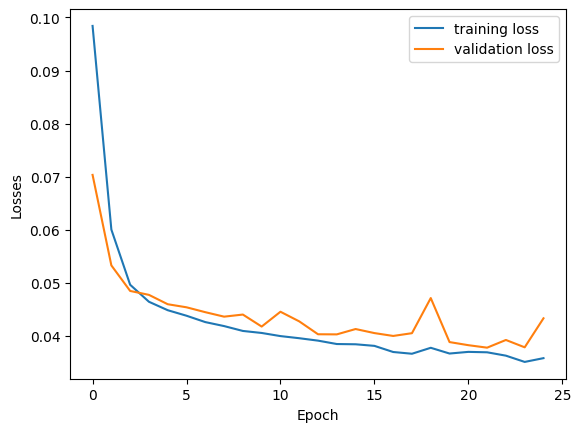

----------
Epoch 26/100
train Loss: 0.0353
val Loss: 0.0566


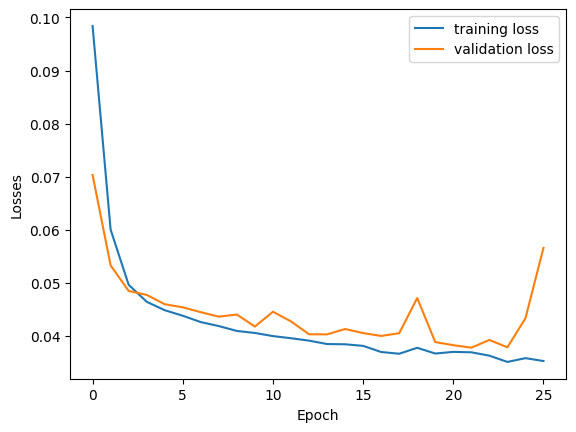

----------
Epoch 27/100
train Loss: 0.0350
val Loss: 0.0398


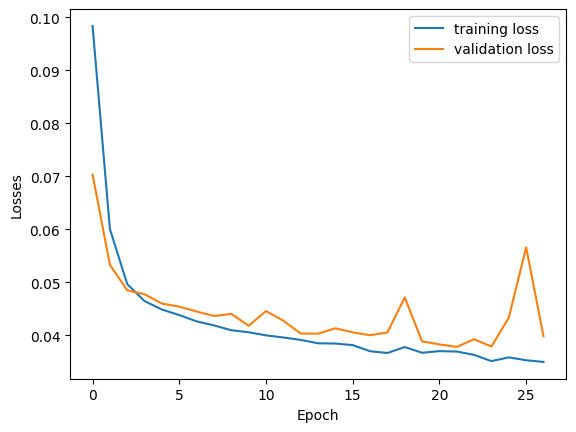

----------
Epoch 28/100
train Loss: 0.0348
val Loss: 0.0375
PASSED
Performance on test_set
Evaluation Loss: 0.0341


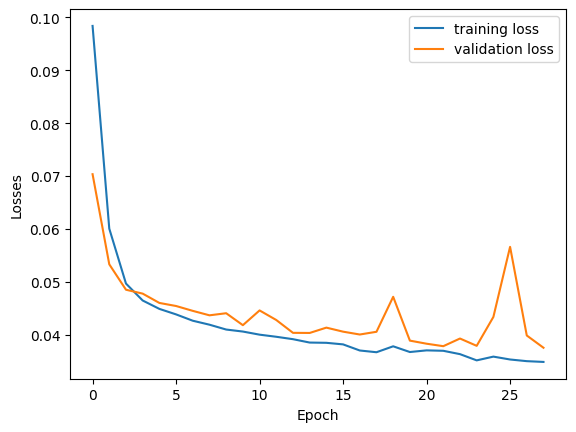

----------
Epoch 29/100
train Loss: 0.0348
val Loss: 0.0365
PASSED
Performance on test_set
Evaluation Loss: 0.0321


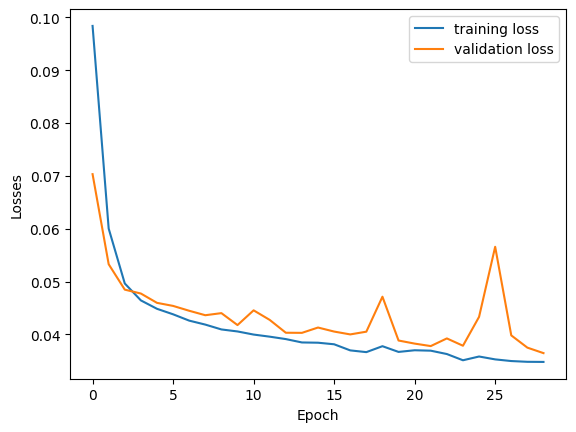

----------
Epoch 30/100
train Loss: 0.0345
val Loss: 0.0379


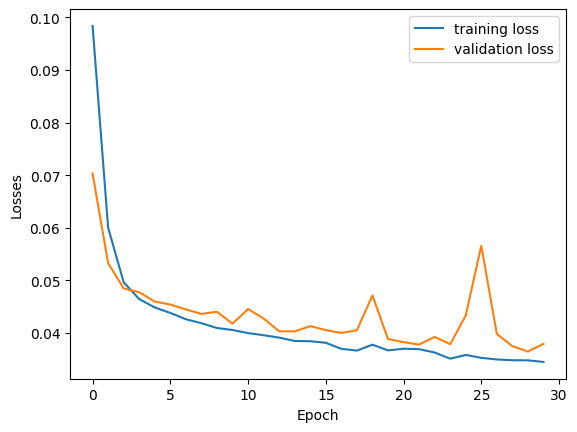

----------
Epoch 31/100
train Loss: 0.0351
val Loss: 0.0371


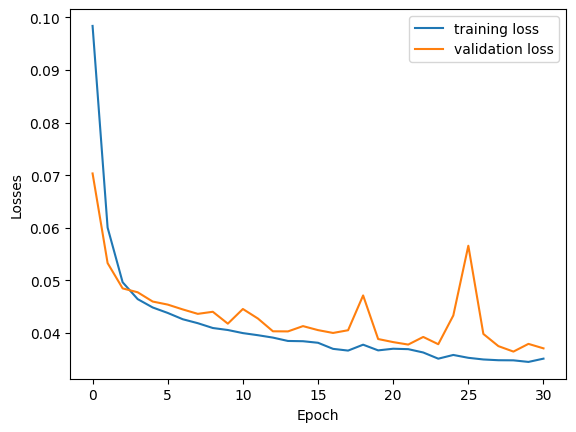

----------
Epoch 32/100
train Loss: 0.0345
val Loss: 0.0372


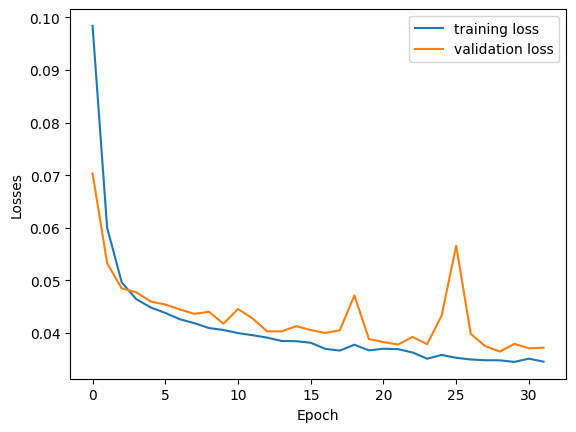

----------
Epoch 33/100
train Loss: 0.0352
val Loss: 0.0407


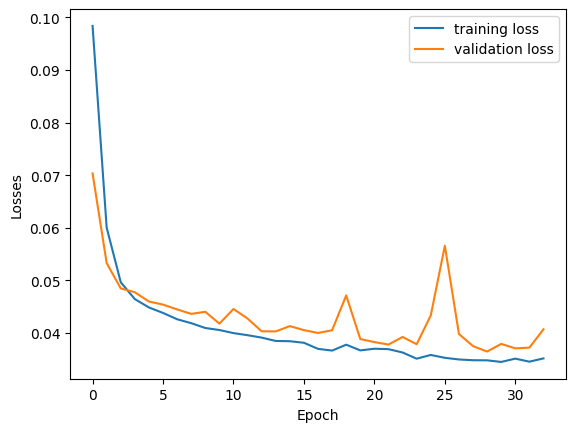

----------
Epoch 34/100
train Loss: 0.0345
val Loss: 0.0390


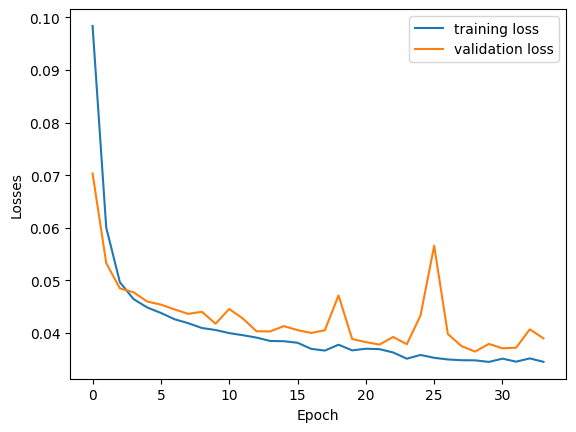

----------
Epoch 35/100
train Loss: 0.0344
val Loss: 0.0418


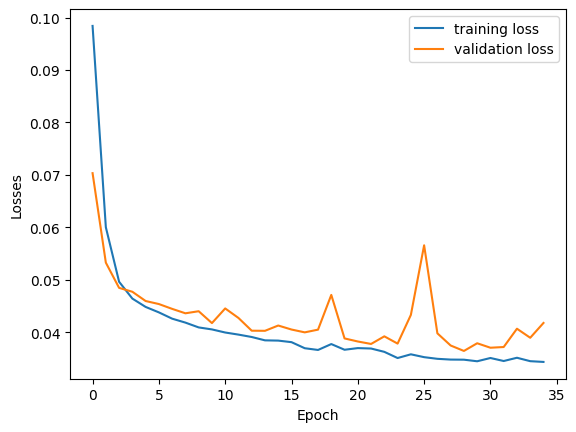

----------
Epoch 36/100
train Loss: 0.0343
val Loss: 0.0370


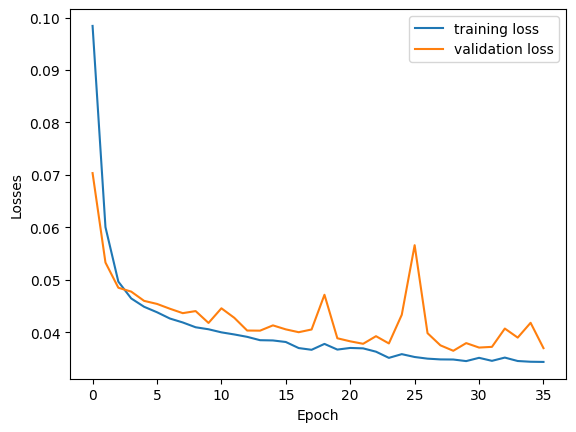

----------
Epoch 37/100
train Loss: 0.0340
val Loss: 0.0365


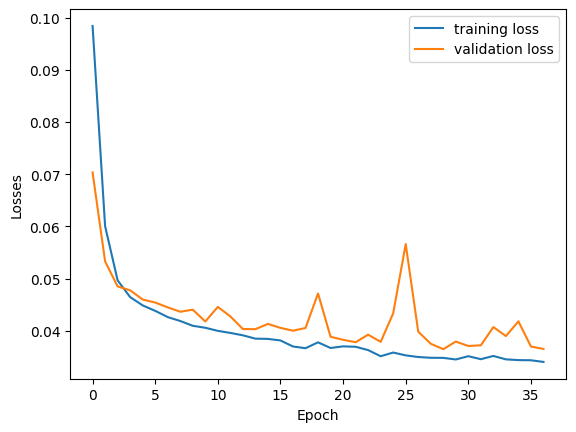

----------
Epoch 38/100
train Loss: 0.0341
val Loss: 0.0364
PASSED
Performance on test_set
Evaluation Loss: 0.0322


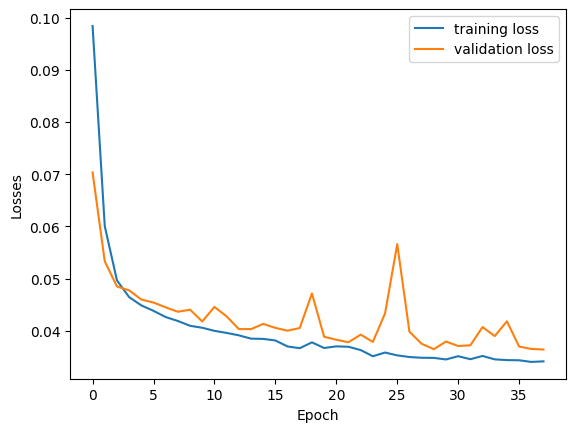

----------
Epoch 39/100
train Loss: 0.0337
val Loss: 0.0390


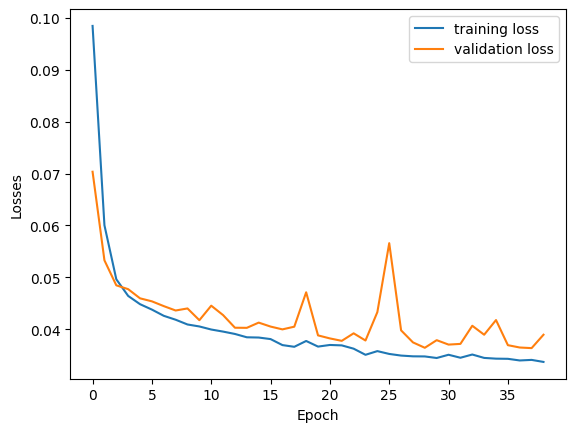

----------
Epoch 40/100
train Loss: 0.0340
val Loss: 0.0415


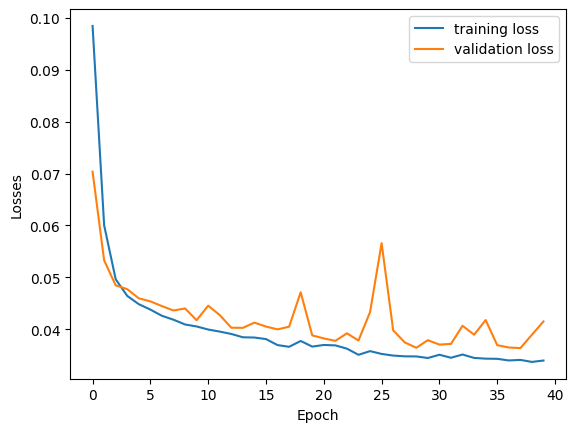

----------
Epoch 41/100
train Loss: 0.0336
val Loss: 0.0392


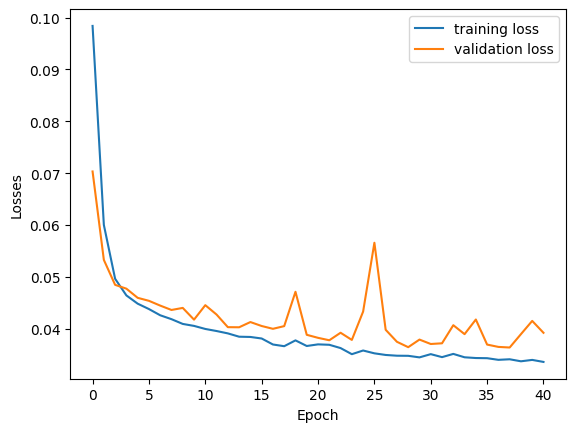

----------
Epoch 42/100
train Loss: 0.0346
val Loss: 0.0374


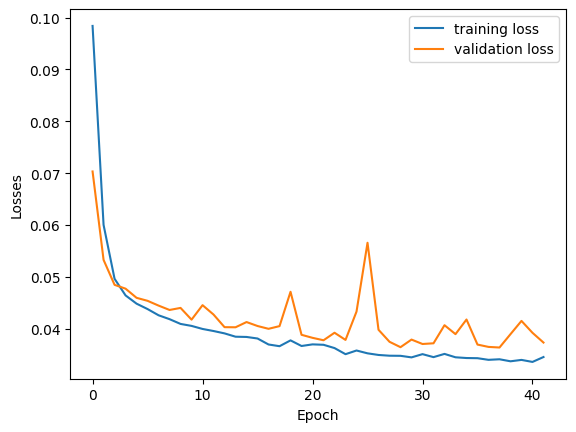

----------
Epoch 43/100
train Loss: 0.0338
val Loss: 0.0391


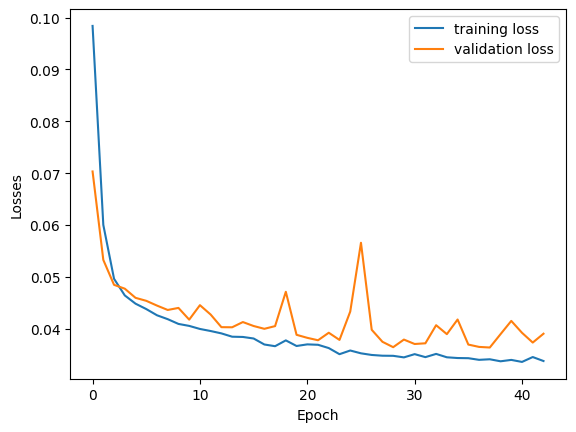

----------
Epoch 44/100
train Loss: 0.0337
val Loss: 0.0385


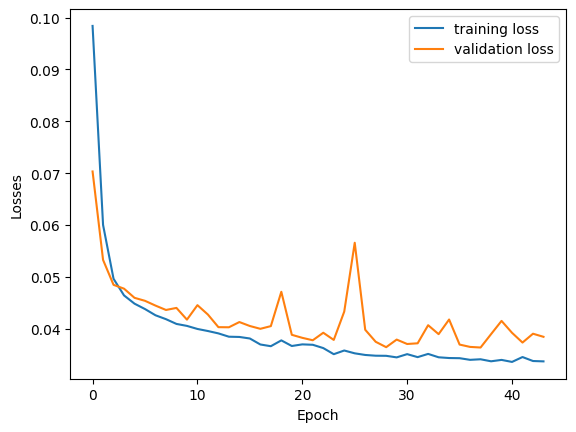

----------
Epoch 45/100
train Loss: 0.0333
val Loss: 0.0368


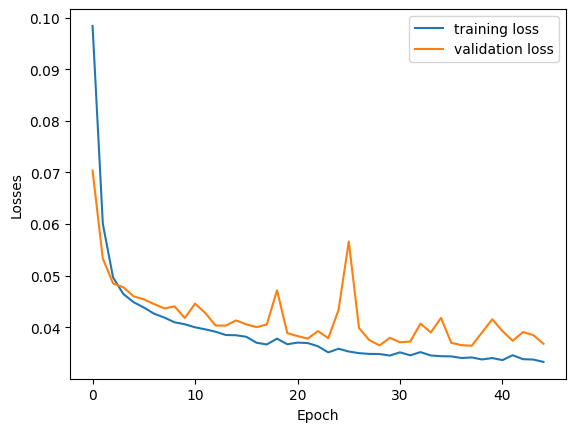

----------
Epoch 46/100
train Loss: 0.0335
val Loss: 0.0368


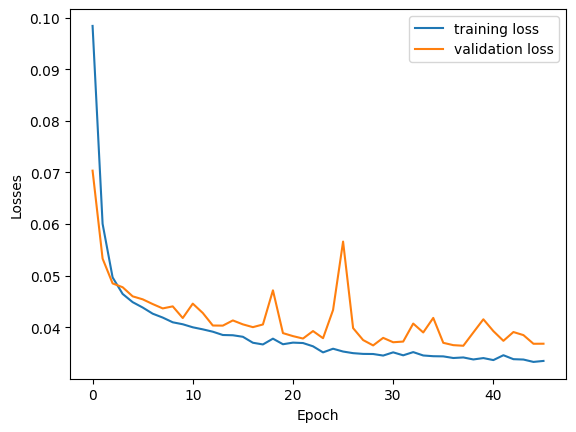

----------
Epoch 47/100
train Loss: 0.0337
val Loss: 0.0362
PASSED
Performance on test_set
Evaluation Loss: 0.0327


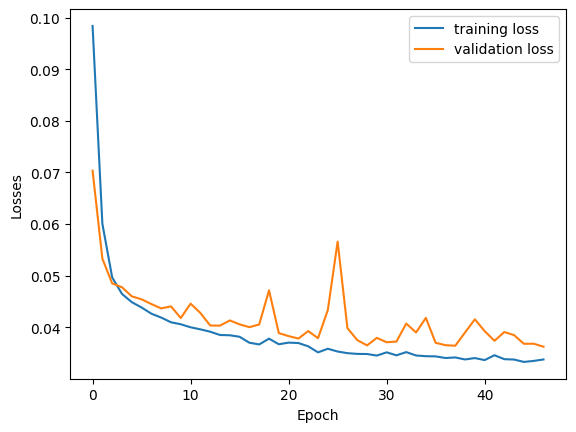

----------
Epoch 48/100
train Loss: 0.0332
val Loss: 0.0380


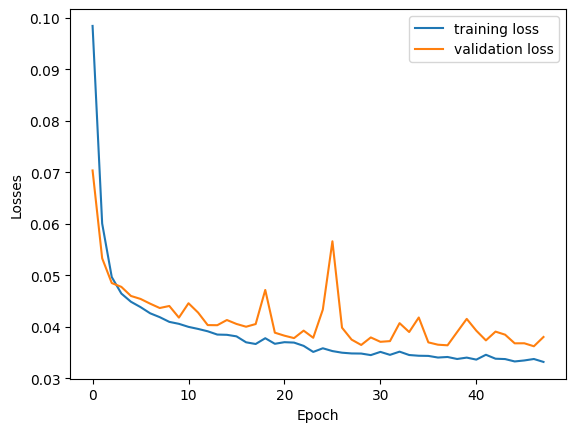

----------
Epoch 49/100
train Loss: 0.0331
val Loss: 0.0375


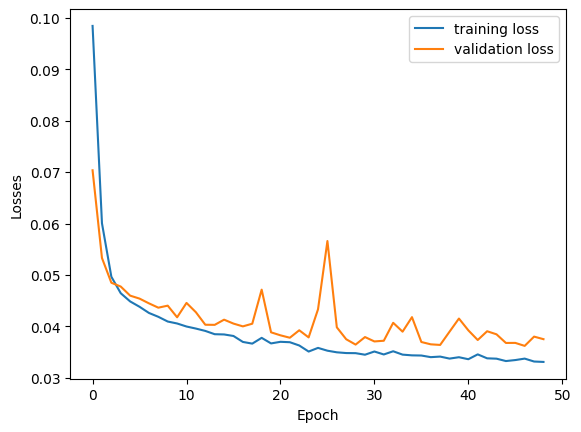

----------
Epoch 50/100
train Loss: 0.0331
val Loss: 0.0385


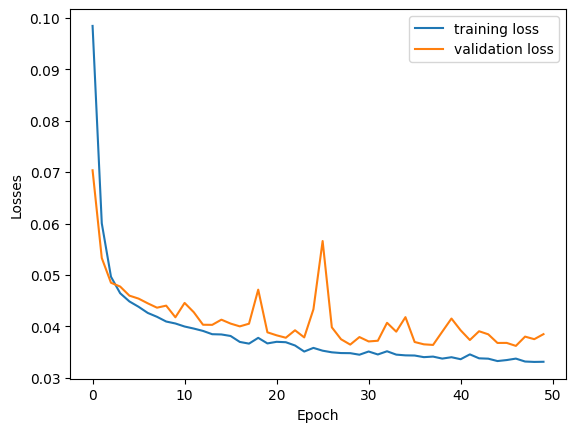

----------
Epoch 51/100
train Loss: 0.0331
val Loss: 0.0370


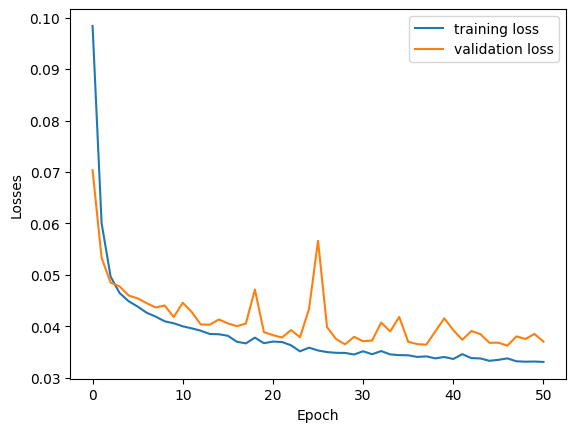

----------
Epoch 52/100
train Loss: 0.0331
val Loss: 0.0363


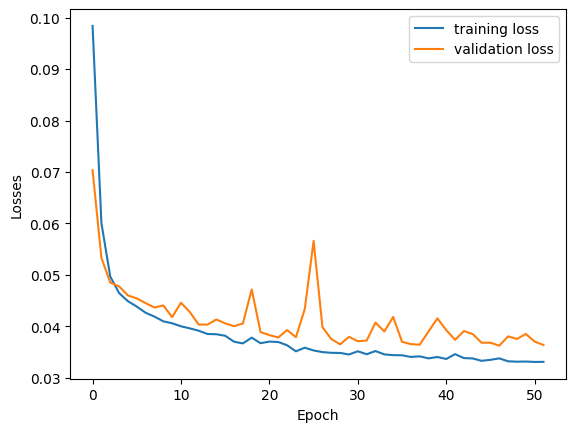

----------
Epoch 53/100
train Loss: 0.0332
val Loss: 0.0364


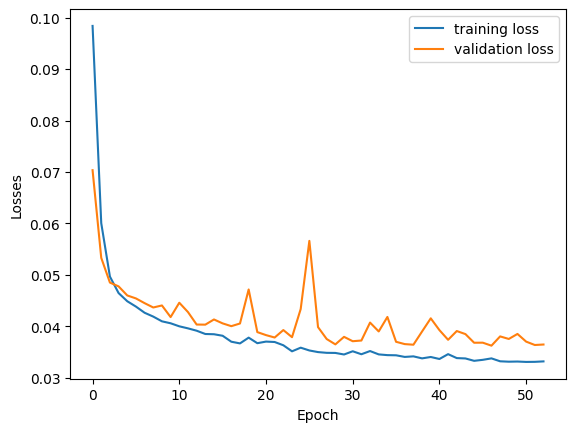

----------
Epoch 54/100
train Loss: 0.0333
val Loss: 0.0363


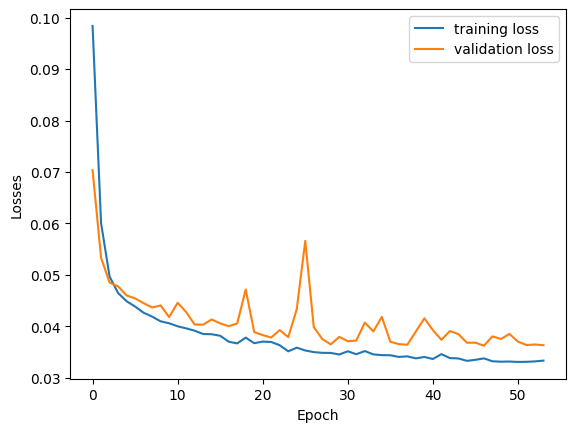

----------
Epoch 55/100
train Loss: 0.0329
val Loss: 0.0382


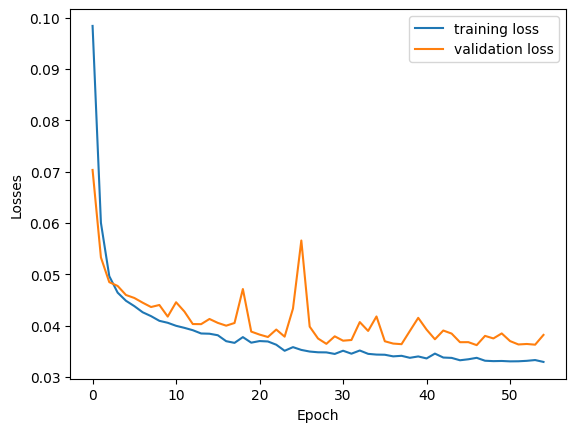

----------
Epoch 56/100
train Loss: 0.0330
val Loss: 0.0372


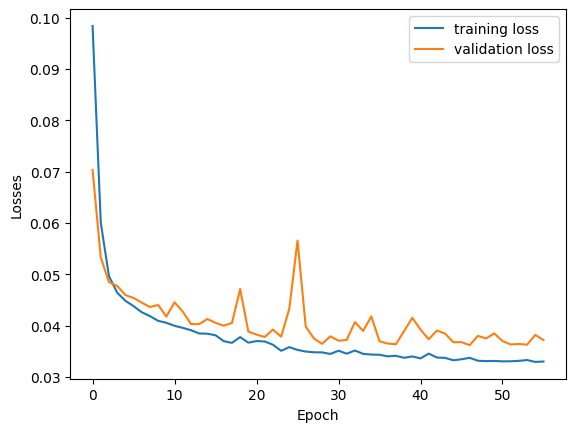

----------
Epoch 57/100
train Loss: 0.0331
val Loss: 0.0374


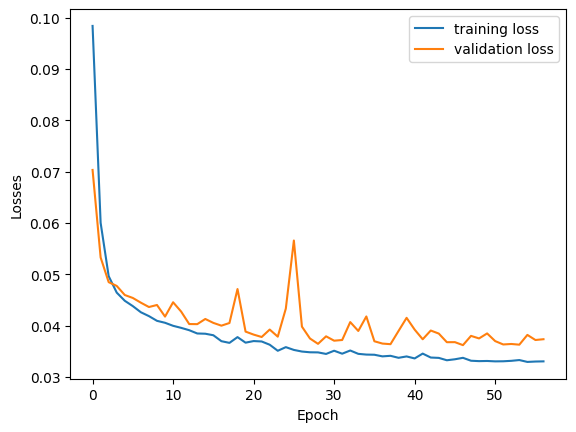

----------
Epoch 58/100
train Loss: 0.0330
val Loss: 0.0359
PASSED
Performance on test_set
Evaluation Loss: 0.0321


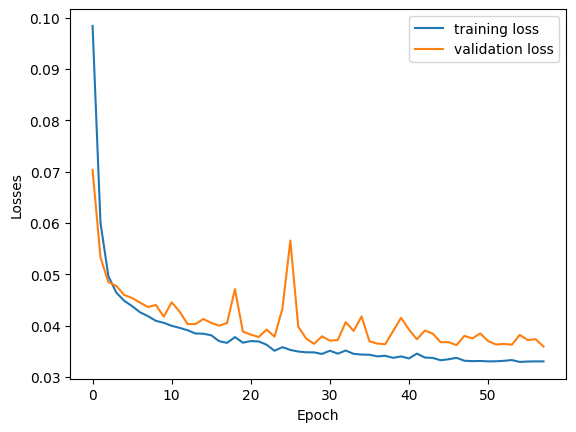

----------
Epoch 59/100
train Loss: 0.0327
val Loss: 0.0360


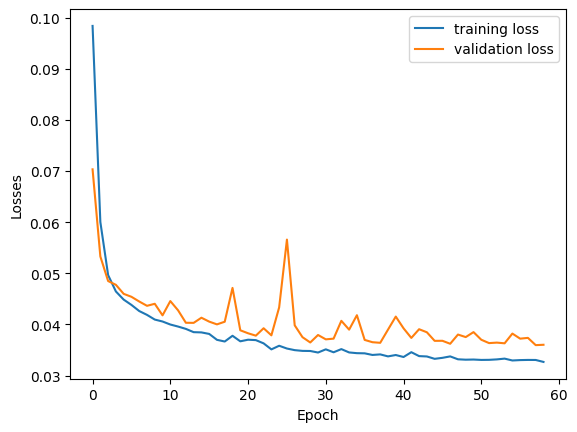

----------
Epoch 60/100
train Loss: 0.0328
val Loss: 0.0356
PASSED
Performance on test_set
Evaluation Loss: 0.0316


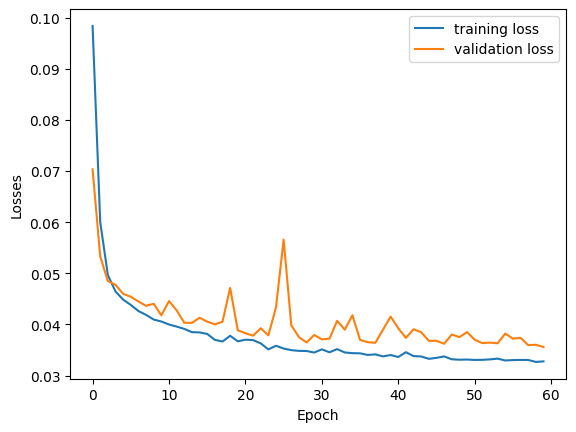

----------
Epoch 61/100
train Loss: 0.0328
val Loss: 0.0369


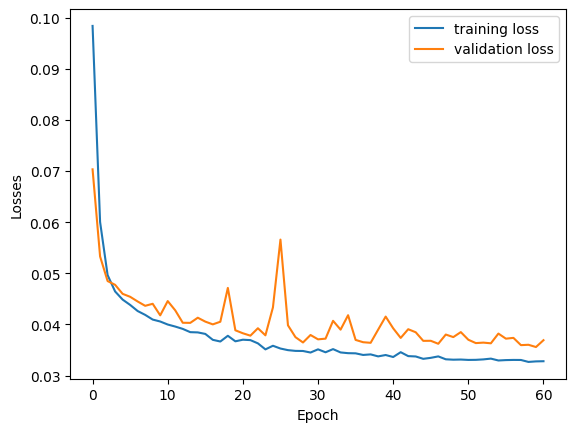

----------
Epoch 62/100
train Loss: 0.0326
val Loss: 0.0350
PASSED
Performance on test_set
Evaluation Loss: 0.0318


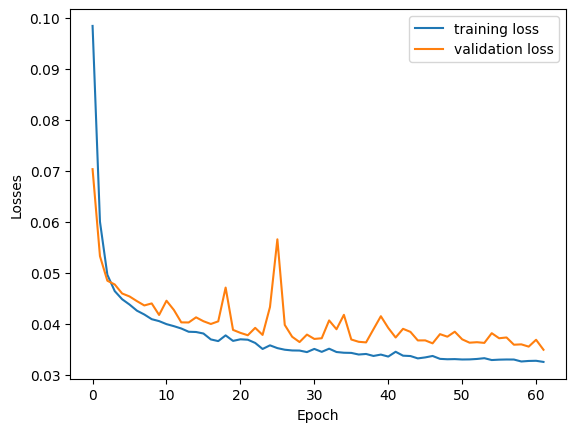

----------
Epoch 63/100
train Loss: 0.0326
val Loss: 0.0351


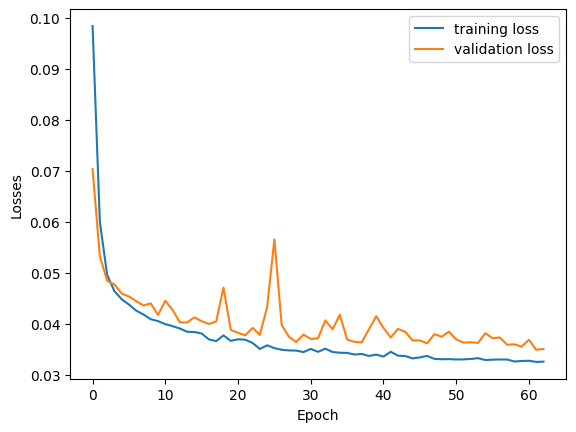

----------
Epoch 64/100
train Loss: 0.0325
val Loss: 0.0358


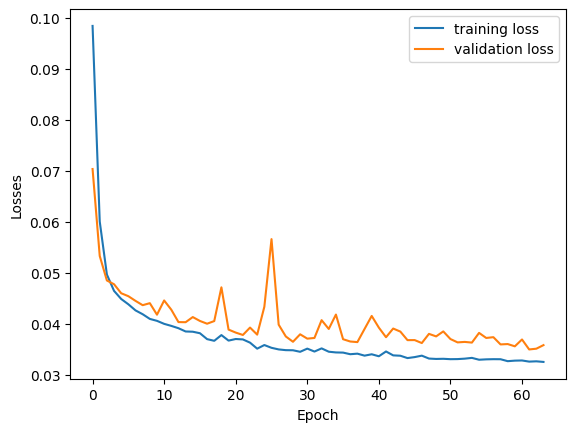

----------
Epoch 65/100
train Loss: 0.0324
val Loss: 0.0360


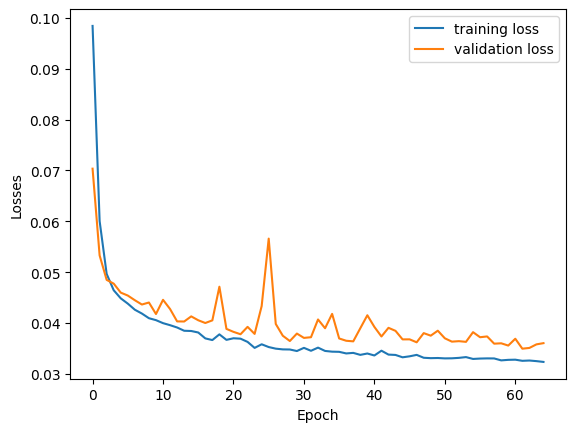

----------
Epoch 66/100
train Loss: 0.0323
val Loss: 0.0369


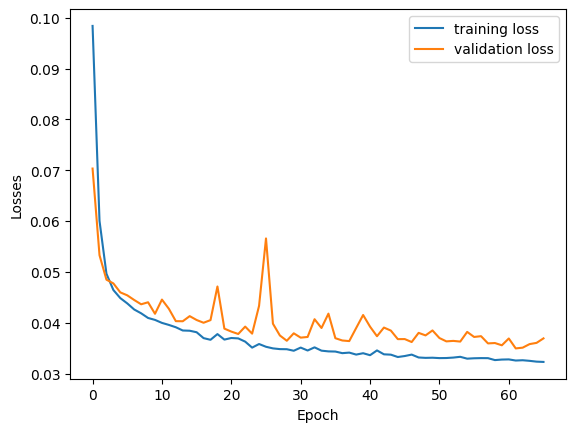

----------
Epoch 67/100
train Loss: 0.0323
val Loss: 0.0353


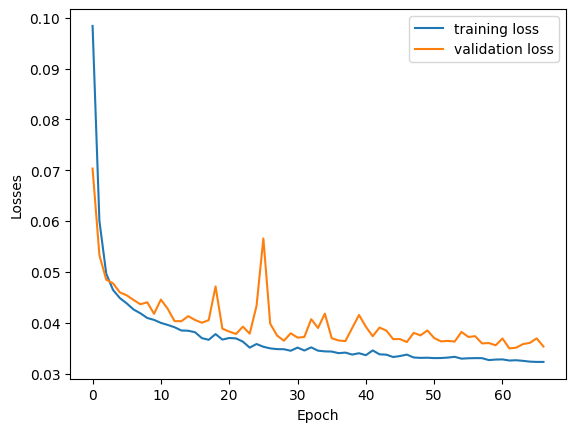

----------
Epoch 68/100
train Loss: 0.0325
val Loss: 0.0354


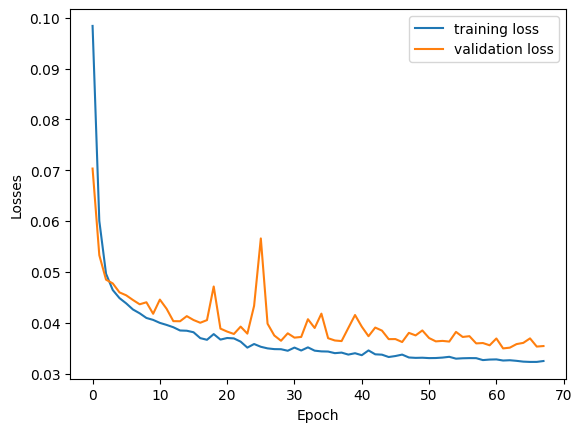

----------
Epoch 69/100
train Loss: 0.0322
val Loss: 0.0350


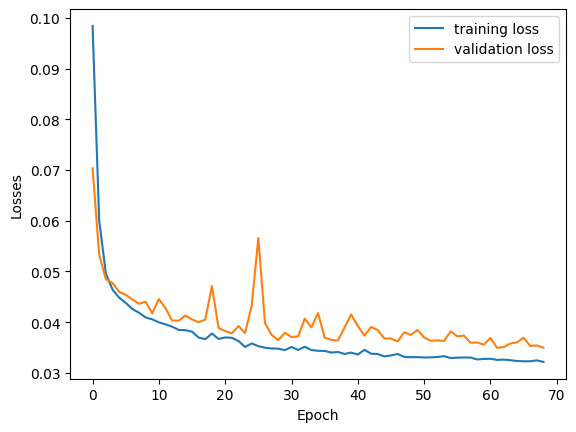

----------
Epoch 70/100
train Loss: 0.0319
val Loss: 0.0366


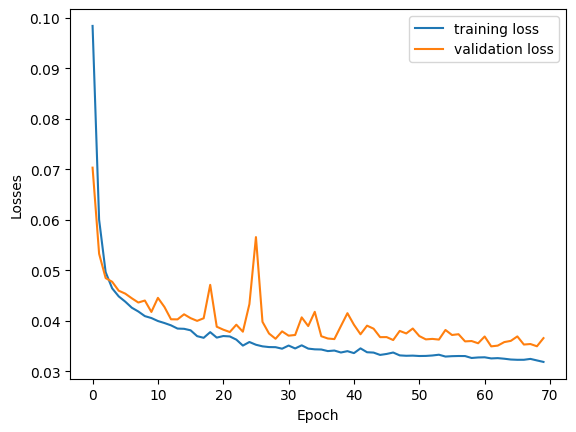

----------
Epoch 71/100
train Loss: 0.0325
val Loss: 0.0371


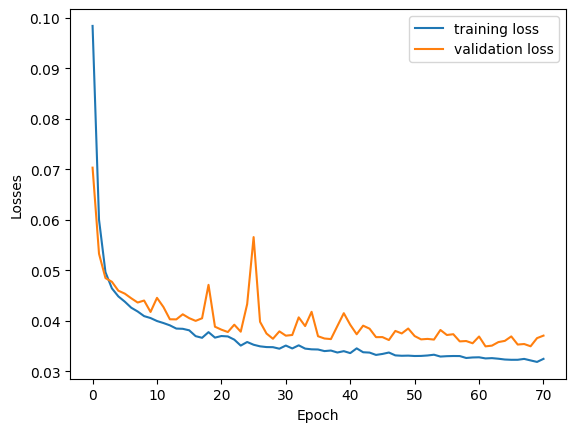

----------
Epoch 72/100
train Loss: 0.0323
val Loss: 0.0347
PASSED
Performance on test_set
Evaluation Loss: 0.0315


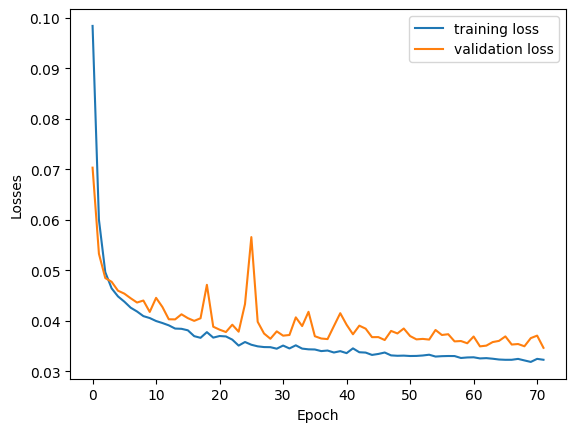

----------
Epoch 73/100
train Loss: 0.0320
val Loss: 0.0353


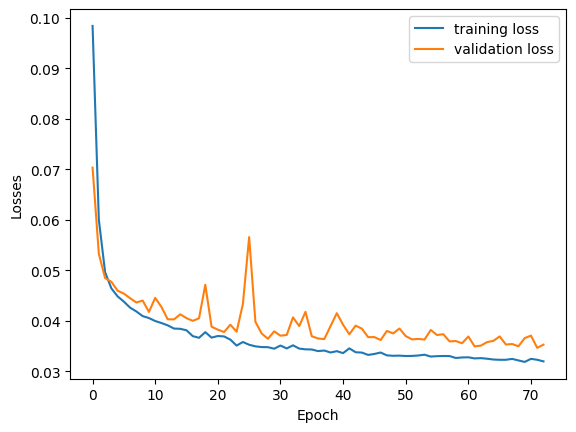

----------
Epoch 74/100
train Loss: 0.0318
val Loss: 0.0348


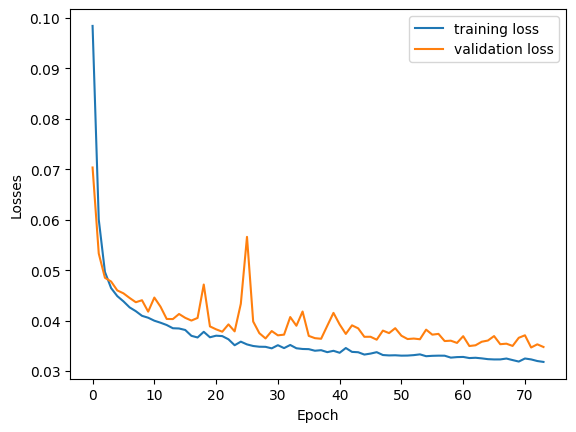

----------
Epoch 75/100
train Loss: 0.0316
val Loss: 0.0357


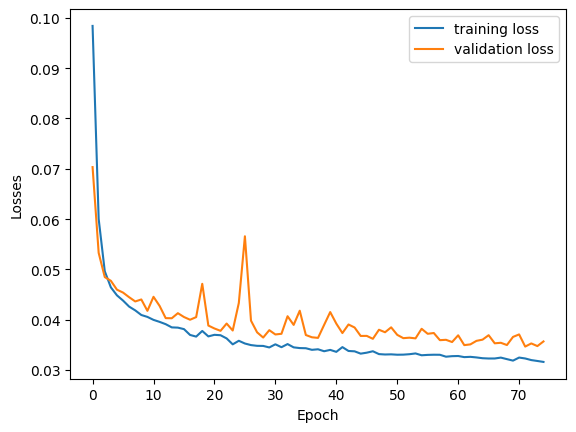

----------
Epoch 76/100
train Loss: 0.0315
val Loss: 0.0348


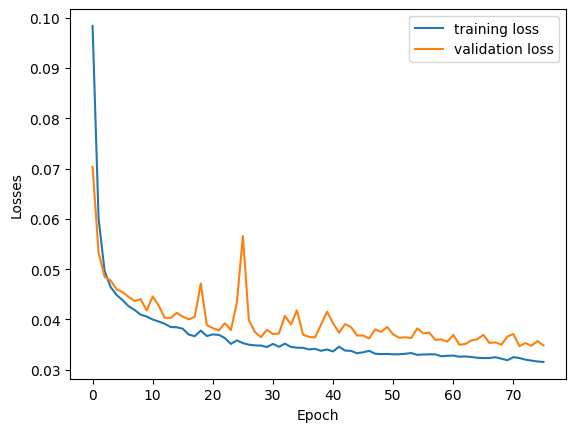

----------
Epoch 77/100
train Loss: 0.0317
val Loss: 0.0355


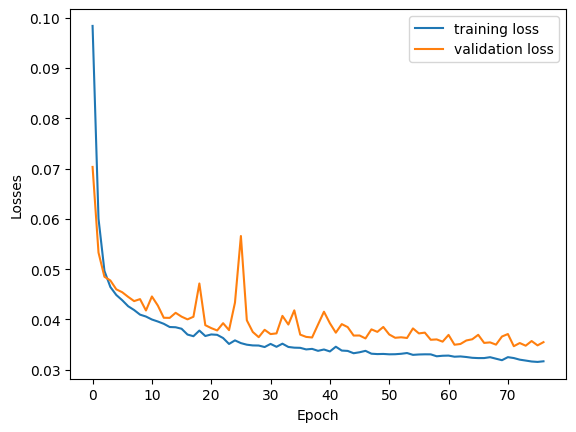

----------
Epoch 78/100
train Loss: 0.0316
val Loss: 0.0346
PASSED
Performance on test_set
Evaluation Loss: 0.0316


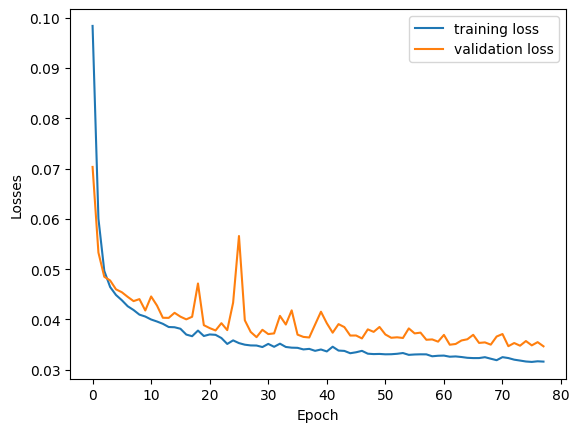

----------
Epoch 79/100
train Loss: 0.0317
val Loss: 0.0346
PASSED
Performance on test_set
Evaluation Loss: 0.0316


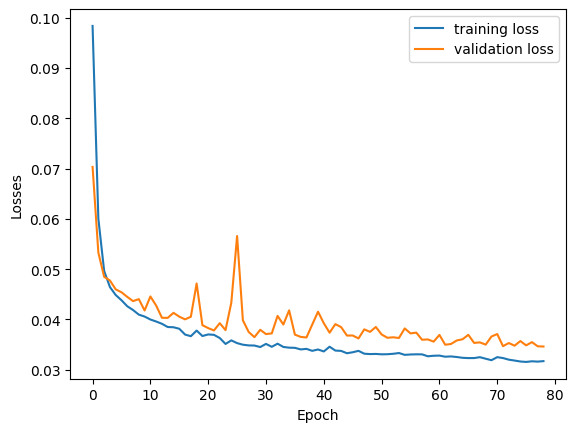

----------
Epoch 80/100
train Loss: 0.0319
val Loss: 0.0352


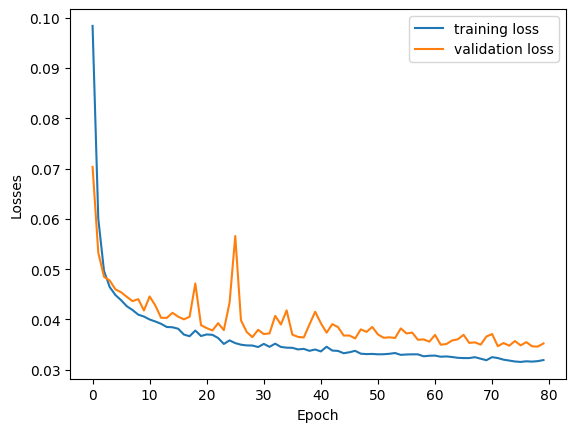

----------
Epoch 81/100
train Loss: 0.0313
val Loss: 0.0346
PASSED
Performance on test_set
Evaluation Loss: 0.0315


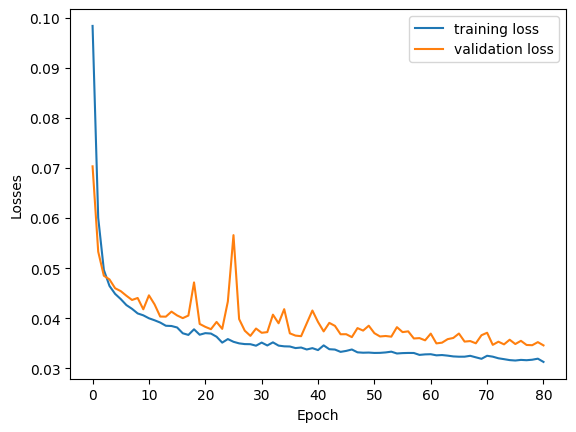

----------
Epoch 82/100
train Loss: 0.0313
val Loss: 0.0348


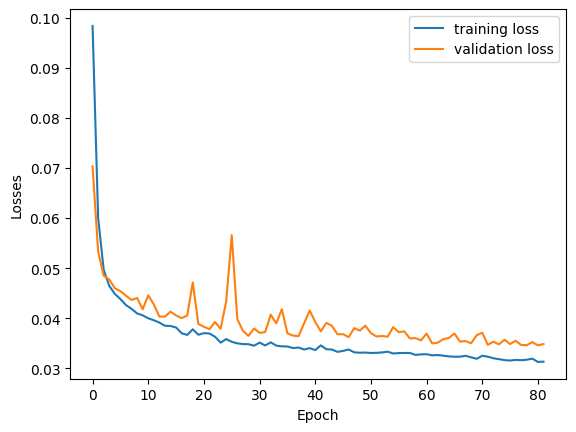

----------
Epoch 83/100
train Loss: 0.0315
val Loss: 0.0350


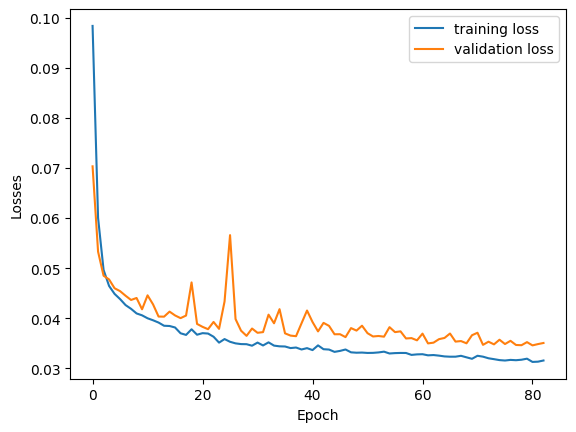

----------
Epoch 84/100
train Loss: 0.0312
val Loss: 0.0347


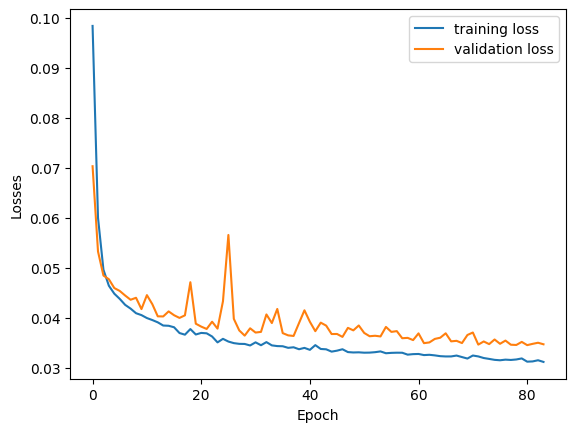

----------
Epoch 85/100
train Loss: 0.0313
val Loss: 0.0347


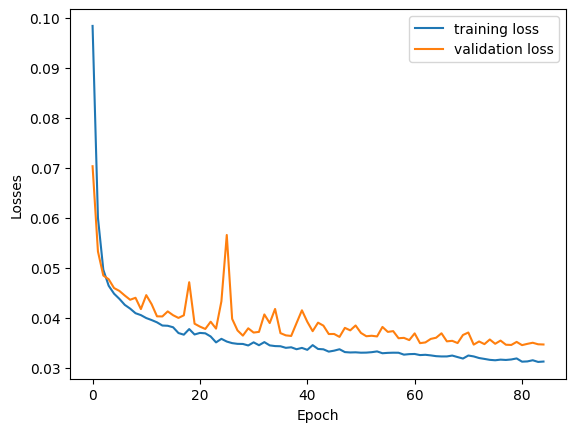

----------
Epoch 86/100
train Loss: 0.0313
val Loss: 0.0348


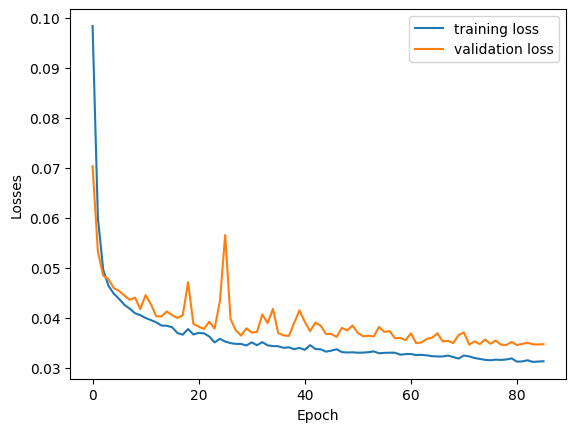

----------
Epoch 87/100
train Loss: 0.0310
val Loss: 0.0347


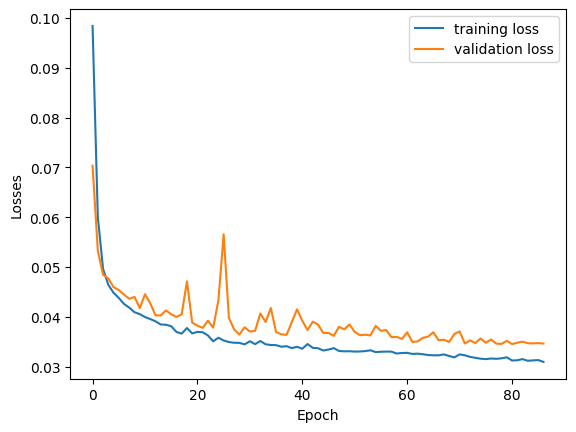

----------
Epoch 88/100
train Loss: 0.0311
val Loss: 0.0347


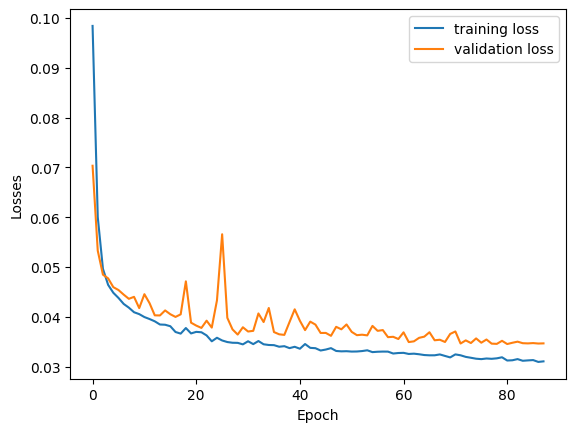

----------
Epoch 89/100
train Loss: 0.0309
val Loss: 0.0346


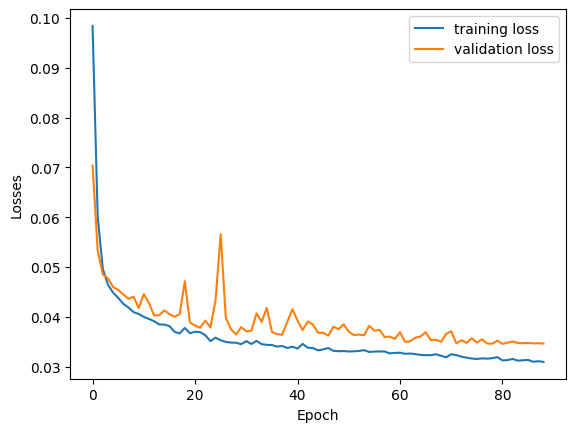

----------
Epoch 90/100
train Loss: 0.0313
val Loss: 0.0346


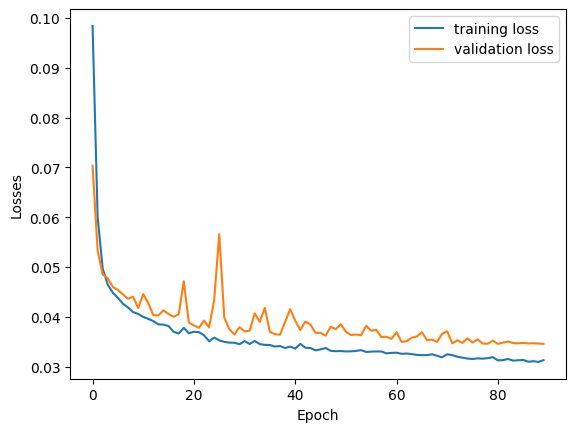

----------
Epoch 91/100
train Loss: 0.0309
val Loss: 0.0348


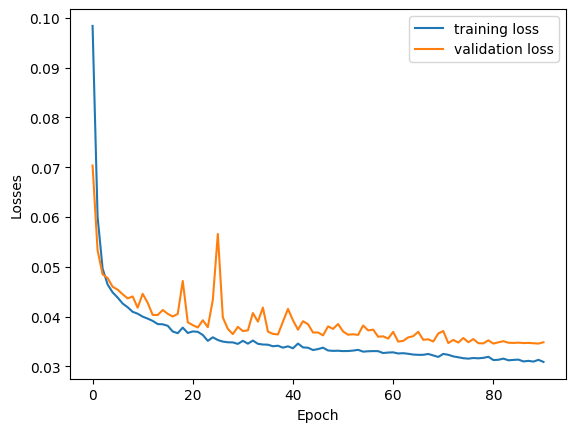

----------
Epoch 92/100
train Loss: 0.0312
val Loss: 0.0346


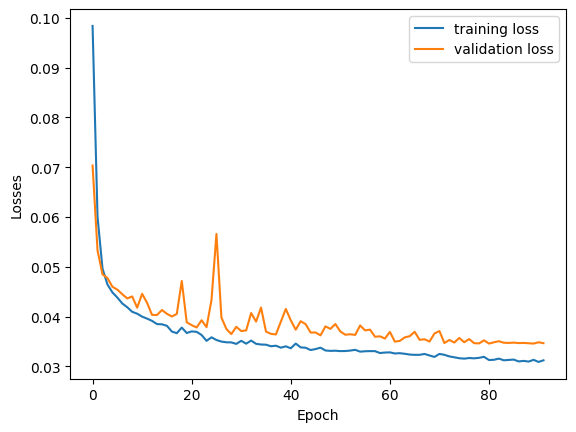

----------
Epoch 93/100
train Loss: 0.0310
val Loss: 0.0346
PASSED
Performance on test_set
Evaluation Loss: 0.0313


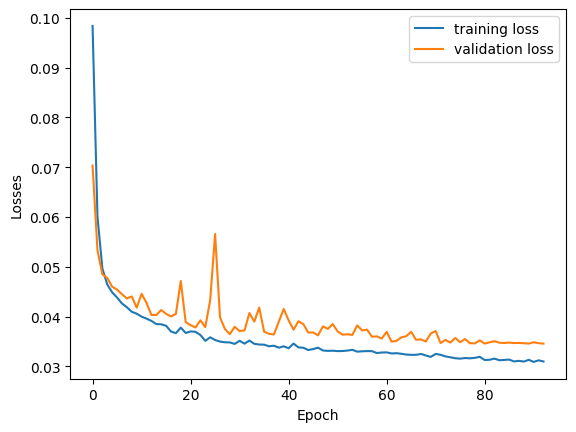

----------
Epoch 94/100
train Loss: 0.0311
val Loss: 0.0345
PASSED
Performance on test_set
Evaluation Loss: 0.0313


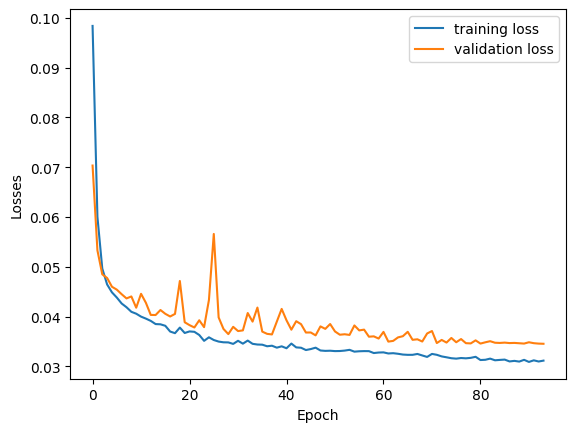

----------
Epoch 95/100
train Loss: 0.0308
val Loss: 0.0346


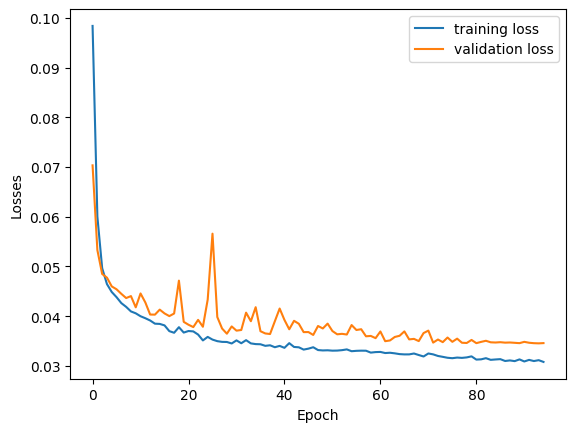

----------
Epoch 96/100
train Loss: 0.0308
val Loss: 0.0346


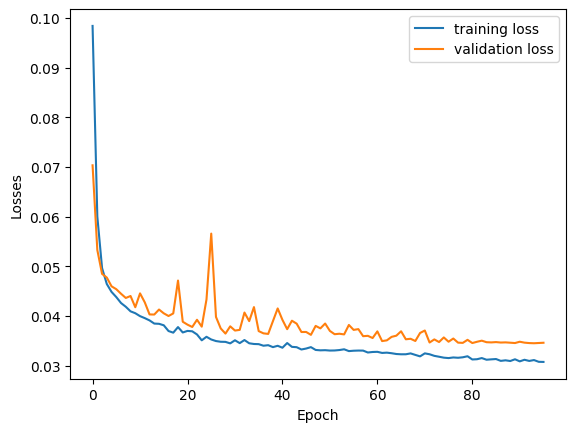

----------
Epoch 97/100
train Loss: 0.0309
val Loss: 0.0346


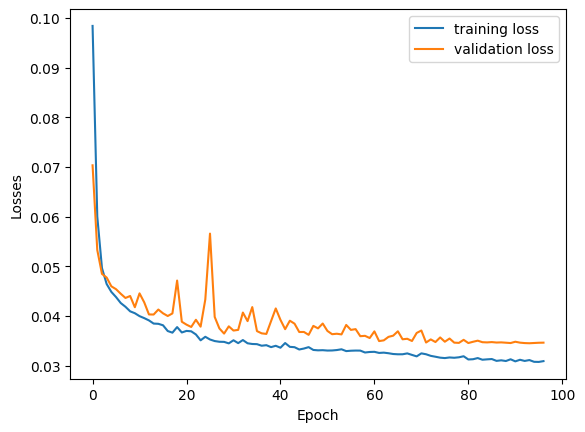

----------
Epoch 98/100
train Loss: 0.0309
val Loss: 0.0346


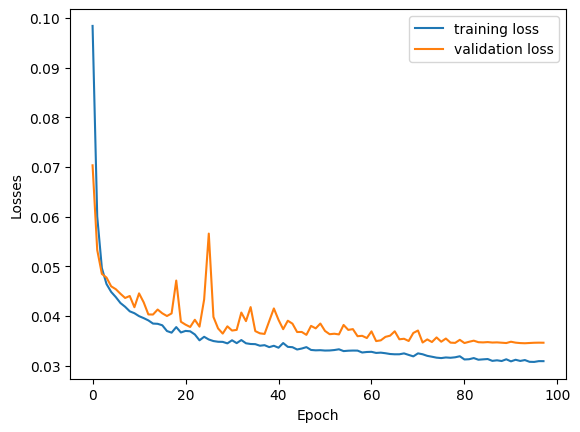

----------
Epoch 99/100
train Loss: 0.0310
val Loss: 0.0346


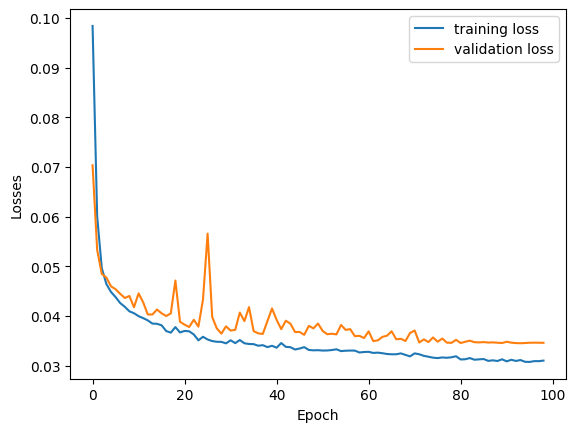

----------
Epoch 100/100
train Loss: 0.0308
val Loss: 0.0346


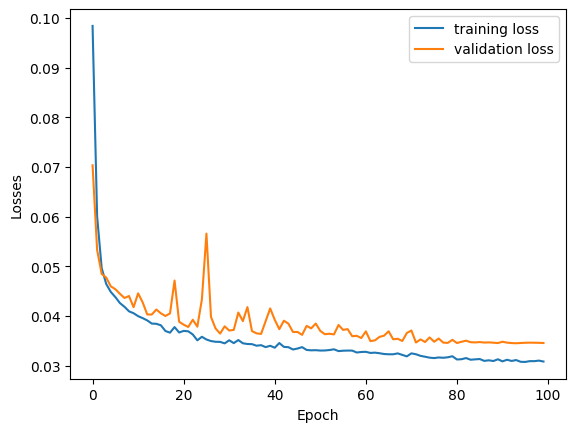

Training complete in 21m 18s
Best val Loss: 0.034526


In [197]:
model = train_model(model, criterion, l1_weight, l2_weight, optimizer, scheduler,
                       num_epochs=epochs, model_filename='NNmodel.pt')

In [198]:
real_test = pd.read_csv('test.csv')



In [ ]:
exper = exper.merge(pred_df, how="left", left_on='tile_path', right_on='img_name')

In [211]:
torch.save(model.state_dict(), 'something.pt')

In [258]:
predictions = predict(model, criterion, l1_weight, l2_weight, optimizer, 'real_test')

Outputs shape: torch.Size([4096, 2])


In [259]:
preds = predictions.transpose(1,0)

In [260]:
preds

array([[ 4.59969282e+00, -3.81546879e+00,  1.17564000e+05],
       [ 3.73220587e+00, -3.25289869e+00,  1.17565000e+05],
       [ 4.69541836e+00, -4.26167393e+00,  1.17566000e+05],
       ...,
       [ 5.34935045e+00, -4.67978048e+00,  1.95938000e+05],
       [ 1.29921269e+00, -1.17480421e+00,  1.95939000e+05],
       [-2.37848902e+00,  2.12238240e+00,  1.95940000e+05]])

In [261]:
unnormalized_probs = preds[:,0:2]
unnormalized_probs

array([[ 4.59969282, -3.81546879],
       [ 3.73220587, -3.25289869],
       [ 4.69541836, -4.26167393],
       ...,
       [ 5.34935045, -4.67978048],
       [ 1.29921269, -1.17480421],
       [-2.37848902,  2.1223824 ]])

In [262]:
SM = nn.Softmax(dim=1)
normalized_probs = np.array(SM(torch.tensor(unnormalized_probs)).detach().numpy())

In [264]:
preds = preds[:,2]
preds

array([117564., 117565., 117566., ..., 195938., 195939., 195940.])

In [265]:
preds.shape

(78377,)

In [266]:
normalized_probs.shape

(78377, 2)

In [267]:
# make a dataframe with the unnormalized probabilities and the preds
pred_df = pd.DataFrame(np.concatenate((preds.reshape(-1,1), normalized_probs), axis=1), columns=['id', 'prob_1', 'prob_2'])

In [268]:
pred_df.head()

,id,prob_1,prob_2
0,117564.0,0.999779,0.000221
1,117565.0,0.999075,0.000925
2,117566.0,0.999871,0.000129
3,117567.0,0.949323,0.050677
4,117568.0,0.997129,0.002871


In [269]:
pred_df.drop('prob_1', axis=1, inplace=True)

In [270]:
pred_df.rename(columns={'prob_2': 'Class'}, inplace=True)

In [274]:
# convert the id column to int
pred_df['id'] = pred_df['id'].astype(int)



In [275]:
pred_df.to_csv('NN_submission.csv', index=False)